## Crustal Thickness grids for Mars

Make some crustal thickness grids for Mars that can be input to the vh0 magnetic modelling code

The first examples are almost entirely reliant on the code here, see also Wieczorek et al (2019 JGR):
https://markwieczorek.github.io/ctplanet/

The final case is loading and resampling the grid of Goosens et al (2017, GRL), taken from here:
https://pgda.gsfc.nasa.gov/products/63

In [1]:
# set path to local copy of ctplanet
import sys
sys.path.append('/Users/simon/GIT/geophys/ctplanet-master/')


import os
import pyshtools as pysh

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from ctplanet import pyMoho
from ctplanet import pyMohoRho
from ctplanet import HydrostaticShapeLith
from ctplanet import HydrostaticShape
from ctplanet import ReadRefModel

In [2]:
# The below example is based on the Mars examples in the ctplanet 'examples' folder
# https://github.com/MarkWieczorek/ctplanet/tree/master/examples
#
# In this case, we:
# - include the corrections for the polar caps
# - use the TAYAK reference model for Mars' interior structure (as in Wieczorek et al, 2019)
# - use constant density either side of the dichotomy boundary (although the code here includes
# - the option to use different densities in the north and south)
# - the thickness at the InSight landing site is hard-coded (to 40 km)
# - the main purpose of the function is to allow models with different lmax to be used, since a
#   smoother model may be better suited for input to the forward magnetic calculation


def generate_crustal_thickness_grid(lmax_calc):

    densityfile = 'ctplanet-Data/dichotomy_359.sh'
    northpolarcap = 'ctplanet-Data/Mars_NorthPolarCapThickness719.sh.gz'
    southpolarcap = 'ctplanet-Data/Mars_SouthPolarCapThickness719.sh.gz'

    model_name = ['DWThot', 'DWThotCrust1', 'DWThotCrust1r', 'EH45Tcold',
                  'EH45TcoldCrust1', 'EH45TcoldCrust1r', 'EH45ThotCrust2',
                  'EH45ThotCrust2r', 'LFAK', 'SANAK', 'TAYAK', 'DWAK',
                  'ZG_DW', 'YOTHotRc1760kmDc40km', 'YOTHotRc1810kmDc40km']
    spec = 'ctplanet-Data/Mars-reference-interior-models/Smrekar/'
    interior_file = [spec + name + '.deck' for name in model_name]

    #lmax_calc = 90
    lmax = lmax_calc * 4

    potential = pysh.datasets.Mars.GMM3()

    print('Gravity file = {:s}'.format('GMM3'))
    print('Lmax of potential coefficients = {:d}'.format(potential.lmax))
    print('Reference radius (km) = {:f}'.format(potential.r0 / 1.e3))
    print('GM = {:e}\n'.format(potential.gm))

    topo = pysh.datasets.Mars.MarsTopo2600(lmax=lmax)
    topo_grid = topo.pad(lmax).expand(grid='DH2')

    print('Topography file = {:s}'.format('MarsTopo2600'))
    print('Lmax of topography coefficients = {:d}'.format(topo.lmax))
    print('Reference radius (km) = {:f}\n'.format(topo.coeffs[0, 0, 0] / 1.e3))

    print('Crustal density file = {:s}'.format(densityfile))
    dichotomy = pysh.SHCoeffs.from_file(densityfile).pad(lmax=lmax)

    print('Lmax of density coefficients = {:d}\n'.format(dichotomy.lmax))

    # read polar cap thicknesses up to lmax
    npc = pysh.SHCoeffs.from_file(northpolarcap, lmax=lmax)
    spc = pysh.SHCoeffs.from_file(southpolarcap, lmax=lmax)
    rho_npc = 1250.
    rho_spc = 1300.

    print('North polar cap thickness file = {:s}'.format(northpolarcap))
    print('Lmax of North polar cap coefficients = {:d}'.format(npc.lmax))
    print('Assumed density of the North polar cap (kg m-3) = {:e}'
          .format(rho_npc))
    print('South polar cap thickness file = {:s}'.format(southpolarcap))
    print('Lmax of South polar cap coefficients = {:d}'.format(spc.lmax))
    print('Assumed density of the South polar cap (kg m-3) = {:e}'
          .format(rho_npc))

    # Topography excluding the polar caps
    topo_no_pc = topo - npc - spc

    # compute gravitational contribution of the polar caps
    npc_correction = pysh.SHGravCoeffs.from_shape(shape=topo_no_pc+npc,
                                                  rho=1.0,
                                                  gm=potential.gm,
                                                  nmax=8,
                                                  lmax=lmax_calc,
                                                  lmax_grid=lmax,
                                                  lmax_calc=lmax)
    spc_correction = pysh.SHGravCoeffs.from_shape(shape=topo_no_pc + spc,
                                                  rho=1.0,
                                                  gm=potential.gm,
                                                  nmax=8,
                                                  lmax=lmax_calc,
                                                  lmax_grid=lmax,
                                                  lmax_calc=lmax)
    base_correction = pysh.SHGravCoeffs.from_shape(shape=topo_no_pc,
                                                   rho=1.0,
                                                   gm=potential.gm,
                                                   nmax=8,
                                                   lmax=lmax_calc,
                                                   lmax_grid=lmax,
                                                   lmax_calc=lmax)
    pc_correction = rho_npc * npc_correction.change_ref(r0=potential.r0)
    pc_correction += rho_spc * spc_correction.change_ref(r0=potential.r0)
    pc_correction -= (rho_spc + rho_npc) * \
        base_correction.change_ref(r0=potential.r0)

    filter = 1
    half = 50
    nmax = 7
    lmax_hydro = 15
    t_sigma = 5.  # maximum difference between crustal thickness iterations
    omega = pysh.constants.Mars.omega.value

    d_lith = 150.e3

    # Get input model and InSight crustal thickness

    lat_insight = 4.502384
    lon_insight = 135.623447

    t_insight_ref = 40. 
    t_insight_ref *= 1.e3


    rho_south = 2900.
    rho_north = 2900.

    ident = str(int(t_insight_ref / 1.e3))

    #for model in range(len(model_name)):
    model = 10   # here only considering 'TAYAK'
    print('Working on model : {:s}'.format(model_name[model]))

    # --- read 1D reference interior model ---
    radius, rho, i_crust, i_core, i_lith = ReadRefModel(
        interior_file[model], depth=d_lith, quiet=False)

    rho_mantle = rho[i_crust-1]
    rho_core = rho[i_core-1]
    

    print('rho_south = {:f}\n'.format(rho_south) +
          'rho_north = {:f}'.format(rho_north))

    density = dichotomy.copy()
    density = density * (rho_north - rho_south)
    density.coeffs[0, 0, 0] += rho_south
    crustal_porosity = 0.0

    ident = model_name[model] + '-' \
        + str(int(t_insight_ref / 1.e3)) \
        + '-' + str(int(rho_south)) + '-' + str(int(rho_north))

    # Compute gravity contribution from hydrostatic density
    # interfaces
    thickave = 44.e3  # initial guess of average crustal thickness
    r_sigma = topo.coeffs[0, 0, 0] - thickave

    hlm, clm_hydro, mass_model = \
        HydrostaticShapeLith(radius, rho, i_lith, potential, topo,
                             (rho_south + rho_north) / 2, r_sigma,
                             omega, lmax_hydro)

    print('Total mass of model (kg) = {:e}'.format(mass_model))
    print('% of J2 arising from beneath lithosphere = {:f}'
          .format(clm_hydro.coeffs[0, 2, 0] /
                  potential.coeffs[0, 2, 0] * 100.))

    pot_lith = potential.copy()
    pot_lith.coeffs[:, :lmax_hydro+1, :lmax_hydro+1] -= \
        clm_hydro.coeffs[:, :lmax_hydro+1, :lmax_hydro+1]

    t_insight = 1.e9
    thickave = 44.e3    # initial guess of average thickness

    while abs(t_insight_ref - t_insight) > t_sigma:
        # iterate to fit assumed minimum crustal thickness

        moho = pyMohoRho(pot_lith, topo_no_pc, density,
                         crustal_porosity, lmax,
                         rho_mantle, thickave,
                         filter_type=filter,
                         half=half, lmax_calc=lmax_calc,
                         quiet=True,
                         correction=pc_correction,
                         nmax=nmax)
        moho_grid = moho.pad(lmax).expand(grid='DH2')

        thick_grid = topo_grid - moho_grid
        t_insight = (topo.pad(lmax) -
                     moho.pad(lmax)).expand(lat=lat_insight,
                                            lon=lon_insight)

        tmin = thick_grid.min()
        tmax = thick_grid.max()
        thickave += t_insight_ref - t_insight

    print('Average crustal thickness (km) = {:f}'
          .format(thickave / 1.e3))
    print('Crustal thickness at InSight landing sites (km) = {:f}'
          .format(t_insight / 1.e3))
    print('Minimum thickness (km) = {:e}'.format(tmin / 1.e3))
    print('Maximum thickness (km) = {:e}'.format(tmax / 1.e3))

    fig, ax = thick_grid.plot(
        show=False,
        colorbar='bottom',
        cb_label='Crustal thickness (km)', cmap_limits=[20000, 90000])
    
    return thick_grid


Gravity file = GMM3
Lmax of potential coefficients = 120
Reference radius (km) = 3396.000000
GM = 4.282837e+13

Topography file = MarsTopo2600
Lmax of topography coefficients = 360
Reference radius (km) = 3389.500122

Crustal density file = ctplanet-Data/dichotomy_359.sh
Lmax of density coefficients = 360

North polar cap thickness file = ctplanet-Data/Mars_NorthPolarCapThickness719.sh.gz
Lmax of North polar cap coefficients = 360
Assumed density of the North polar cap (kg m-3) = 1.250000e+03
South polar cap thickness file = ctplanet-Data/Mars_SouthPolarCapThickness719.sh.gz
Lmax of South polar cap coefficients = 360
Assumed density of the South polar cap (kg m-3) = 1.250000e+03
Working on model : TAYAK
TAYAK
Surface radius of model (km) = 3389.500000
Mantle density (kg/m3) = 3376.460000
Mantle radius (km) = 3314.297200
Core density (kg/m3) = 5965.290000
Core radius (km) = 1791.372600
Assumed depth of optional interface (km) = 150.000000
Actual depth of optional interface in discretize

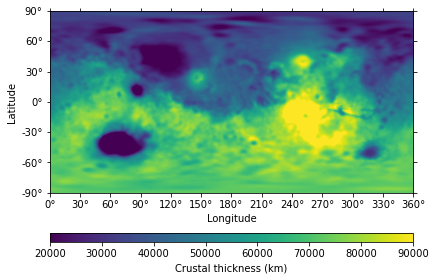

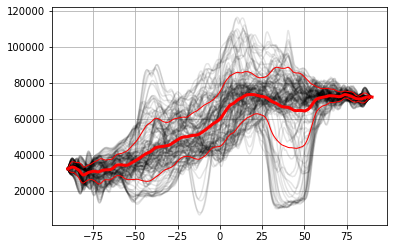

In [4]:
# generate crustal thickness grid using lmax=90, same as Wieczorek
thick_grid_l90 = generate_crustal_thickness_grid(90)

# Make a simple plot to show the latitudinal gradient in compited crustal thickness
plt.figure()
plt.plot(np.linspace(-90,90,thick_grid_l90.nlat), thick_grid_l90.data[:,::10],'k',alpha=0.1)
plt.plot(np.linspace(-90,90,thick_grid_l90.nlat), thick_grid_l90.data.mean(axis=1),linewidth=3,color='r')
plt.plot(np.linspace(-90,90,thick_grid_l90.nlat), thick_grid_l90.data.mean(axis=1)+thick_grid_l90.data.std(axis=1),linewidth=1,color='r')
plt.plot(np.linspace(-90,90,thick_grid_l90.nlat), thick_grid_l90.data.mean(axis=1)-thick_grid_l90.data.std(axis=1),linewidth=1,color='r')
plt.grid()
plt.show()


Gravity file = GMM3
Lmax of potential coefficients = 120
Reference radius (km) = 3396.000000
GM = 4.282837e+13

Topography file = MarsTopo2600
Lmax of topography coefficients = 120
Reference radius (km) = 3389.500122

Crustal density file = ctplanet-Data/dichotomy_359.sh
Lmax of density coefficients = 120

North polar cap thickness file = ctplanet-Data/Mars_NorthPolarCapThickness719.sh.gz
Lmax of North polar cap coefficients = 120
Assumed density of the North polar cap (kg m-3) = 1.250000e+03
South polar cap thickness file = ctplanet-Data/Mars_SouthPolarCapThickness719.sh.gz
Lmax of South polar cap coefficients = 120
Assumed density of the South polar cap (kg m-3) = 1.250000e+03
Working on model : TAYAK
TAYAK
Surface radius of model (km) = 3389.500000
Mantle density (kg/m3) = 3376.460000
Mantle radius (km) = 3314.297200
Core density (kg/m3) = 5965.290000
Core radius (km) = 1791.372600
Assumed depth of optional interface (km) = 150.000000
Actual depth of optional interface in discretize

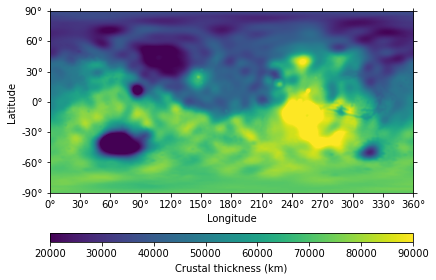

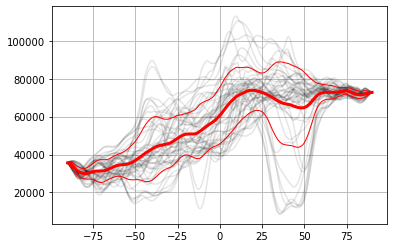

In [5]:
# generate a smooth version, lmax = 30
thick_grid_l30 = generate_crustal_thickness_grid(30)

plt.figure()
plt.plot(np.linspace(-90,90,thick_grid_l30.nlat), thick_grid_l30.data[:,::10],'k',alpha=0.1)
plt.plot(np.linspace(-90,90,thick_grid_l30.nlat), thick_grid_l30.data.mean(axis=1),linewidth=3,color='r')
plt.plot(np.linspace(-90,90,thick_grid_l30.nlat), thick_grid_l30.data.mean(axis=1)+thick_grid_l30.data.std(axis=1),linewidth=1,color='r')
plt.plot(np.linspace(-90,90,thick_grid_l30.nlat), thick_grid_l30.data.mean(axis=1)-thick_grid_l30.data.std(axis=1),linewidth=1,color='r')
plt.grid()
plt.show()


/opt/anaconda3/envs/pygmt/lib/python3.8/site-packages/pyshtools/shclasses/shgrid.py:1272: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 432x289.44 with 2 Axes>,
 <AxesSubplot:xlabel='Longitude', ylabel='Latitude'>)

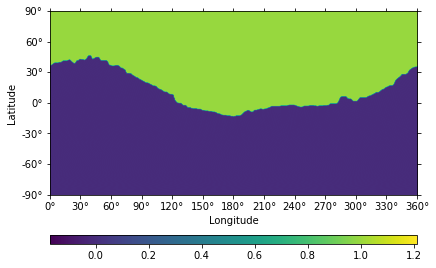

In [6]:
densityfile = 'ctplanet-Data/dichotomy_359.sh'
dichotomy = pysh.SHCoeffs.from_file(densityfile).pad(lmax=90*4)
dichotomy_grid = dichotomy.expand()

dichotomy_grid.plot(colorbar='bottom', show=True)


1439


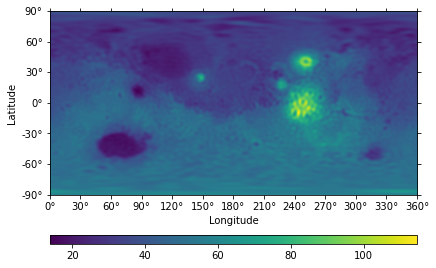

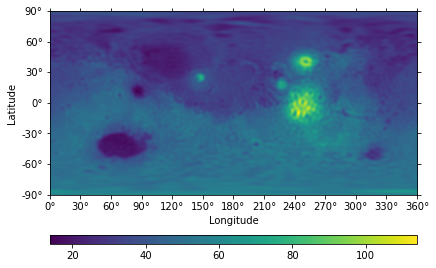

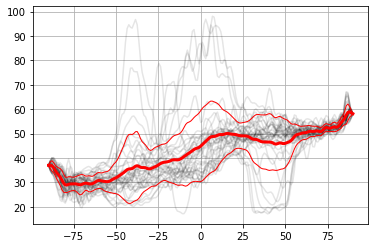

In [7]:
# Note the location of the source file is
# 'https://core2.gsfc.nasa.gov/PGDA/data/MarsDensityRM1/crustal_thickness_gmm3_rm1_constructed_density.grd'

dat = xr.load_dataarray('/Users/simon/Work/Mars/grids/crustal_thickness_gmm3_rm1_constructed_density.grd')

# for some reason, when we load this grid it appears inverted - so manually flip it
dat.data = np.flipud(dat.data)
G17 = pysh.SHGrid.from_xarray(dat)
print(G17.lmax)

G17.plot(colorbar='bottom', show=True)

G17_l90 = G17.expand().expand(lmax=90)
G17_l90.plot(colorbar='bottom', show=True)

plt.figure()
plt.plot(np.linspace(-90,90,G17_l90.nlat), G17_l90.data[:,::10],'k',alpha=0.1)
plt.plot(np.linspace(-90,90,G17_l90.nlat), G17_l90.data.mean(axis=1),linewidth=3,color='r')
plt.plot(np.linspace(-90,90,G17_l90.nlat), G17_l90.data.mean(axis=1)+G17_l90.data.std(axis=1),linewidth=1,color='r')
plt.plot(np.linspace(-90,90,G17_l90.nlat), G17_l90.data.mean(axis=1)-G17_l90.data.std(axis=1),linewidth=1,color='r')
plt.grid()
plt.show()


In [14]:
# Resample the grids to the same grid nodes used as inputs to vh0,
# save to ascii files

G17_l90_resample = G17_l90.to_xarray().interp(lon=np.linspace(0.125,359.875,1440), 
                                              lat=np.linspace(-89.875,89.875,720), method="linear")

thick_grid_l90_resample = thick_grid_l90.to_xarray().interp(lon=np.linspace(0.125,359.875,1440), 
                                                            lat=np.linspace(-89.875,89.875,720), method="linear")

thick_grid_l30_resample = thick_grid_l30.to_xarray().interp(lon=np.linspace(0.125,359.875,1440), 
                                                            lat=np.linspace(-89.875,89.875,720), method="linear")


x,y = np.meshgrid(G17_l90_resample.lon, G17_l90_resample.lat)

fmt = '%1.3f', '%1.3f', '%1.12f'
np.savetxt('grids/G17_l90.xyz', np.vstack((x.flatten(), 
                                           y.flatten(), 
                                           G17_l90_resample.data.flatten())).T, fmt=fmt)
np.savetxt('grids/W19_l90.xyz', np.vstack((x.flatten(), 
                                           y.flatten(), 
                                           thick_grid_l90_resample.data.flatten())).T, fmt=fmt)
np.savetxt('grids/W19_l30.xyz', np.vstack((x.flatten(), 
                                           y.flatten(), 
                                           thick_grid_l30_resample.data.flatten())).T, fmt=fmt)


